In [1]:
%pip install threadpoolctl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
    __global__ void matmul(float *A, float *B, float *C, int m, int k, int n) {
        int i = blockIdx.x * blockDim.x + threadIdx.x;
        int j = blockIdx.y * blockDim.y + threadIdx.y;
        if (i < m && j < n) {
            float sum = 0;
            for (int l = 0; l < k; l++) {
                sum += A[i * k + l] * B[l * n + j];
            }
            C[i * n + j] = sum;
        }
    }
""")

def matmul_gpu(A, B):
    m, k = A.shape
    k, n = B.shape
    C = np.zeros((m, n)).astype(np.float32)

    block_size = (32, 32,1)
    grid_size = ((m + block_size[0] - 1) // block_size[0], (n + block_size[1] - 1) // block_size[1])

    func = mod.get_function("matmul")
    func(cuda.In(A), cuda.In(B), cuda.Out(C), np.int32(m), np.int32(k), np.int32(n), block=block_size, grid=grid_size)

    return C

In [3]:
def matmul_cpu_at_operator(A, B):
    C = A @ B
    return C

In [4]:
def matmul_cpu_dot(A, B):
    C = np.dot(A, B)
    return C

In [5]:
# set the number of threads for many common libraries
from os import environ
# use your number of physical cores


In [6]:
import time
import numpy as np
# Generate random matrices
A = np.random.rand(10000,10000).astype(np.float32)
B = np.random.rand(10000,10000).astype(np.float32)

start_time = time.time()
m, k = A.shape
k, n = B.shape
C = np.zeros((m, n)).astype(np.float32)
end_time = time.time()
zeros_time = end_time - start_time
print("Zero matrix init: {:.3f} s".format(end_time - start_time))

# Time CPU-only implementation 
#start_time = time.time()
#C_cpu_at_operator = matmul_cpu_at_operator(A, B)
#end_time = time.time()
#cpu2_time = end_time - start_time
#print("CPU time np: {:.3f} s".format(end_time - start_time))

from threadpoolctl import threadpool_limits

N_THREADS = 8
with threadpool_limits(limits=N_THREADS, user_api='blas'):
    # Time CPU-only implementation with @ symbol
    start_time = time.time()
    C_cpu_at = matmul_cpu_at_operator(A, B)
    end_time = time.time()
    cpu_at_time = end_time - start_time
    print("CPU time @ operator: {:.3f} s".format(end_time - start_time))

with threadpool_limits(limits=N_THREADS, user_api='blas'):
# Time CPU-only implementation with np.dot
    start_time = time.time()
    C_cpu_dot = matmul_cpu_dot(A, B)
    end_time = time.time()
    cpu_dot_time = end_time - start_time
    print("CPU time np.dot: {:.3f} s".format(end_time - start_time))

# Time PyCUDA-accelerated implementation
start_time = time.time()
C_gpu = matmul_gpu(A, B)
end_time = time.time()
gpu_time = end_time - start_time
print("GPU time: {:.3f} s".format(end_time - start_time))

# Check that results are the same
assert np.allclose(C_cpu_at, C_gpu)
assert np.allclose(C_cpu_dot, C_gpu)

Zero matrix init: 0.238 s
CPU time @ operator: 4.195 s
CPU time np.dot: 4.224 s
GPU time: 10.136 s


CPU time: 4.651 s
GPU time: 10.224 s


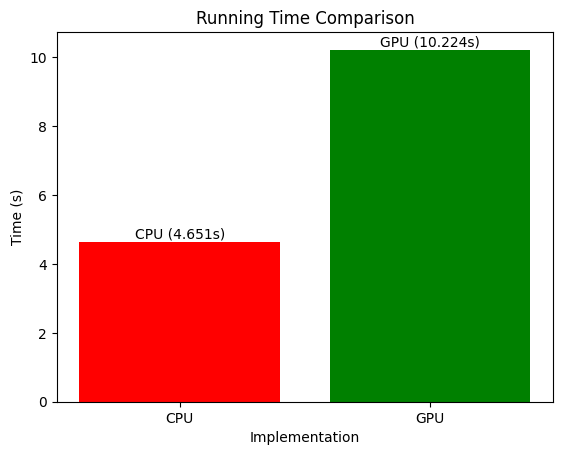

Time Difference: -5.573 s


In [9]:
import matplotlib.pyplot as plt

# ...

with threadpool_limits(limits=N_THREADS, user_api='blas'):
    # Time CPU-only implementation
    start_time = time.time()
    C_cpu = matmul_cpu_at_operator(A, B)
    end_time = time.time()
    cpu_time = end_time - start_time
    print("CPU time: {:.3f} s".format(cpu_time))


# Time PyCUDA-accelerated implementation
start_time = time.time()
C_gpu = matmul_gpu(A, B)
end_time = time.time()
gpu_time = end_time - start_time
print("GPU time: {:.3f} s".format(gpu_time))

# Calculate the time difference
time_diff = cpu_time - gpu_time

# Plot the time difference
labels = ['CPU', 'GPU']
times = [cpu_time, gpu_time]
colors = ['red', 'green']
plt.bar(labels, times, color=colors)
plt.xlabel('Implementation')
plt.ylabel('Time (s)')
plt.title('Running Time Comparison')

# Add time labels to the plot
for i in range(len(labels)):
    plt.text(i, times[i], '{} ({:.3f}s)'.format(labels[i], times[i]), ha='center', va='bottom')

plt.show()

# Print the time difference
print("Time Difference: {:.3f} s".format(time_diff))
